In [7]:
from pynwb import NWBHDF5IO
from nwbwidgets import nwb2widget
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
# load the nwb files
filename = '..//data//NWBFile//test.nwb'

io = NWBHDF5IO(filename,'r')
nwbfile = io.read()


In [3]:
nwb2widget(nwbfile)

In [9]:
ecephys = nwbfile.get_acquisition('ecephys')
ecephys

ecephys pynwb.ecephys.ElectricalSeries at 0x2566329631752
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (13107234, 64), type "<f8">
  description: local field potential data cleaned by singer lab preprocessing pipeline
  electrodes: electrodes <class 'hdmf.common.table.DynamicTableRegion'>
  rate: 2000.0
  resolution: -1.0
  starting_time: 0.0
  starting_time_unit: seconds
  unit: volts

In [10]:
data = ecephys.data

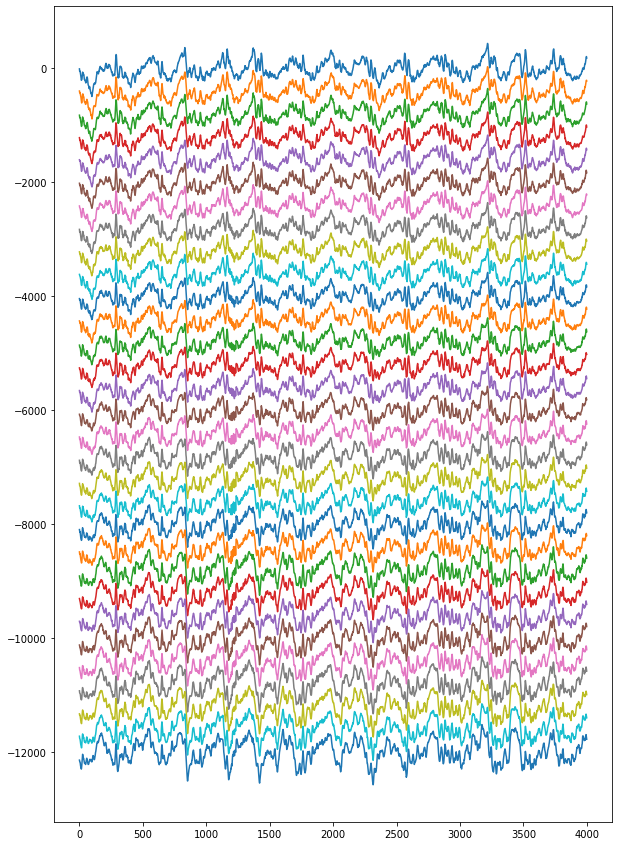

In [24]:
fig = plt.figure(figsize=(10,15))
for ch in range(31):
    plt.plot(data[0:4000,ch]-400*ch)

plt.show()